In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.8.1


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [4]:
dataset = raw_dataset.copy()

In [5]:
dataset = dataset.dropna()

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

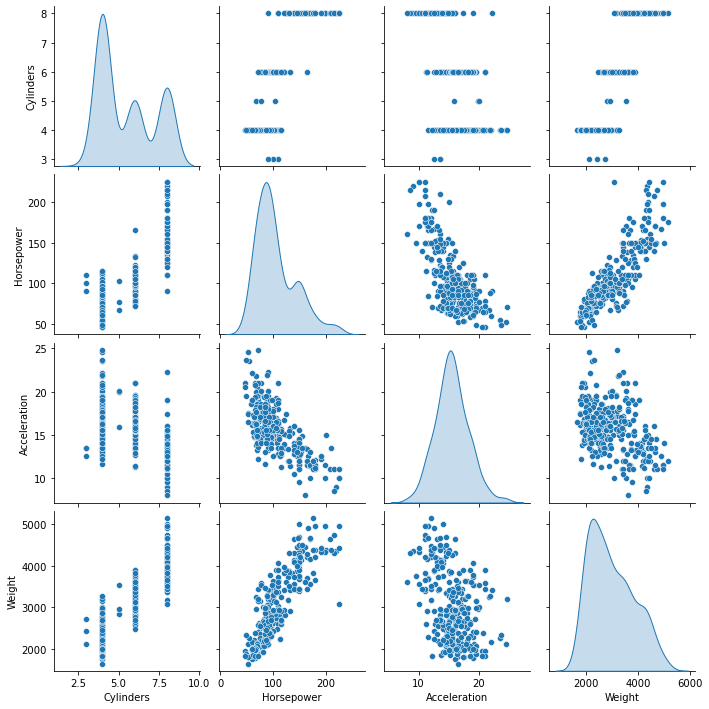

In [9]:
sns.pairplot(train_dataset[['Cylinders', 'Horsepower', 'Acceleration', 'Weight']], diag_kind='kde')


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Horsepower')
test_labels = test_features.pop('Horsepower')

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)


In [12]:
normalizer.adapt(np.array(train_features))


2022-08-23 13:51:38.978377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print(normalizer.mean.numpy())


[[  23.311    5.478  195.318 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [15]:
acceleration = np.array(train_features['Acceleration'])

acceleration_normalizer = layers.Normalization(input_shape=[1,], axis=None)
acceleration_normalizer.adapt(acceleration)



In [16]:
acceleration_model = tf.keras.Sequential([
    acceleration_normalizer,
    layers.Dense(units=1)
])

acceleration_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [17]:
acceleration_model.predict(acceleration[:10])


array([[-0.61 ],
       [ 1.002],
       [-1.185],
       [-0.495],
       [ 1.405],
       [ 0.944],
       [ 1.865],
       [ 3.592],
       [ 0.541],
       [ 1.98 ]], dtype=float32)

In [18]:
acceleration_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [33]:
%%time
history = acceleration_model.fit(
    train_features['Acceleration'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)



CPU times: user 1.63 s, sys: 10.7 ms, total: 1.64 s
Wall time: 5.21 s


In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,21.660109,22.734753,95
96,21.660152,22.739958,96
97,21.663662,22.720839,97
98,21.659904,22.731821,98
99,21.661282,22.756878,99


In [35]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [acceleration]')
  plt.legend()
  plt.grid(True)


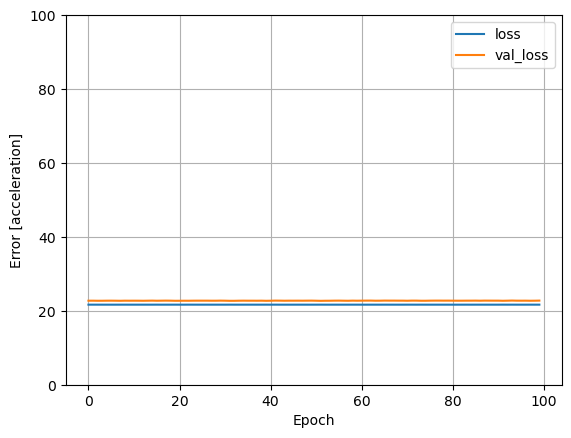

In [36]:
plot_loss(history)


In [37]:
test_results = {}

test_results['acceleration_model'] = acceleration_model.evaluate(
    test_features['Acceleration'],
    test_labels, verbose=0)



In [38]:
x = tf.linspace(0.0, 50, 51)
y = acceleration_model.predict(x)


In [39]:
def plot_acceleration(x, y):
  plt.scatter(train_features['Acceleration'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Acceleration')
  plt.ylabel('Horsepower')
  plt.legend()



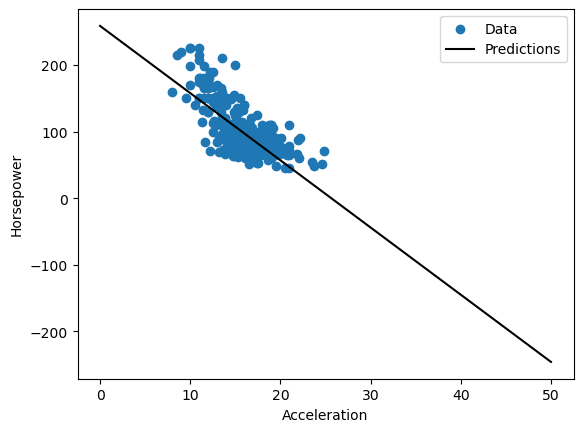

In [40]:
plot_acceleration(x, y)

